# Armory-Library Tutorial

In this tutorial, we will demonstrate how to run an example in armory-library
with an example model and dataset. In this tutorial we will use the mnist
dataset for simplicity and a model via HuggingFace that was pre-trained on the
mnist dataset.

## Package Installs

In addition to the `armory-library` package, we install the `datasets` package
because we will use it later to retrieve a dataset from the HuggingFace hub. 

In [ ]:
# !pip install --upgrade armory-library
# !pip install --upgrade datasets
# !pip install numpy==1.24

## Imports

These are all the necessary imports to run the example file and will all be used and explained later in the notebook.

In [ ]:
import json
from pprint import pprint

from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import datasets
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import torch
import torch.nn
import torchmetrics.classification
from transformers import AutoImageProcessor, AutoModelForImageClassification

from armory.data import DataType, ImageDimensions, NumpySpec, Scale, TorchSpec
from armory.dataset import ImageClassificationDataLoader
from armory.engine import EvaluationEngine
import armory.evaluation as ev
from armory.export import Exporter
from armory.export.criteria import every_n_batches
from armory.export.image_classification import ImageClassificationExporter
from armory.metric import PerturbationMetric, PredictionMetric
from armory.metrics.compute import BasicProfiler
from armory.metrics.perturbation import PerturbationNormMetric
from armory.model.image_classification import ImageClassifier
from armory.perturbation import ArtEvasionAttack

ModuleNotFoundError: No module named 'armory.logs'

In [ ]:
batch_size = 8
num_batches = 10

We define some runtime parameters here. These can be overwritten externally
via papermill (e.g., `-p batch_size 4`). Modify these as necessary based on your
host resource constraints.

## Define the Evaluation

In [ ]:
evaluation = ev.Evaluation(
    name="mnist-vit-pgd",
    description="MNIST image classification using a ViT model and PGD attack",
    author="TwoSix",
)

We start by creating an Armory evaluation instance with some basic information.
To this evaluation, we will add evaluation chains. Each chain describes the
input dataset, any perturbations that will be applied to input samples, the
model to generate predictions based on the input, any metrics to be calculated
from the predictions, and any exporters to save samples.

## Loading and Wrapping the Dataset

In [ ]:
hf_dataset = datasets.load_dataset("mnist", split="test")

We load the dataset from the HuggingFace hub. The "mnist" dataset is the same
one used to pre-train our selected model.

Since we are only performing an evaluation of the already-trained model, we only
load the "test" split.

In [ ]:
labels = hf_dataset.features["label"].names
labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

We obtain the labels from the features of the dataset.

In [ ]:
hf_processor = AutoImageProcessor.from_pretrained(
    "farleyknight-org-username/vit-base-mnist"
)
hf_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Here we load a pre-configured image processor from HuggingFace for our selected
model. This processor ensures that images from the dataset will be formatted
correctly when used as inputs to the model.

By printing the processor to the console or by visually inspecting the
`preprocessor_config.json` file on HuggingFace for the selected model, we can
see that this image processor will:
- Resize images to 224x224.
- Normalize the image data using a mean of `(0.5, 0.5, 0.5)` and a standard
  deviation of `(0.5, 0.5, 0.5)`.

In [ ]:
image_mean = tuple(hf_processor.image_mean)
image_std = tuple(hf_processor.image_std)

image_height = hf_processor.size["height"]
image_width = hf_processor.size["width"]

image_min = 0.0 - max(image_mean) / min(image_std)
image_max = 1.0 - min(image_mean) / min(image_std)

We'll save these parameters from the processor so we can use them later.

We can calculate the minimum and maximum normalized values by taking the
unnormalized min and max (0.0 and 1.0) and applying the normalization equation
using the image processor's mean and standard deviation.

Although unnecessary in this case because the mean and standard deviation is the
same across all three channels, we demonstrate here the calculation using the
largest or smallest values as though each channel had different values (e.g.,
when using the ImageNet normalization values). We use the largest mean value
when calculating the min so we get the lowest negative number possible. But we
use the smallest mean value when calculating the max so we get the highest
positive number possible. We use the smallest standard deviation value in both
cases in the denominator to get the highest and lowest numbers possible.

In [ ]:
def transform(sample):
    sample["image"] = hf_processor([img.convert("RGB") for img in sample["image"]])[
        "pixel_values"
    ]
    return sample

hf_dataset.set_transform(transform)

We write a transform function that will be applied to the dataset. This
transform will convert images to RGB color mode (in case they aren't already)
and then pass them through the pre-configured HuggingFace image processor.

In [ ]:
dataloader = ImageClassificationDataLoader(
    hf_dataset,
    dim=ImageDimensions.CHW,
    scale=Scale(
        dtype=DataType.FLOAT,
        max=1.0,
        mean=image_mean,
        std=image_std,
    ),
    image_key="image",
    label_key="label",
    batch_size=batch_size,
)

dataset = ev.Dataset(
    name="MNIST",
    dataloader=dataloader,
)

Lastly we create a data loader for the dataset. As the data loader is
responsible for creating the self-describing, structured batches of data, it
is objective-specific (i.e., image classification vs object detection) and must
be informed about characteristics of the samples coming out of the dataset (and
any transforms that have been applied).

In our case, we instruct the data loader that the images from the dataset will
have a channels-first dimensionality and have been normalized to a particular
mean and standard deviation. When unnormalized, the data is floating point
values ranging from 0 to 1.0. The `image_key` and `label_key` are the property
names in the sample dictionaries out of the dataset containing the image data
and target labels, respectively.

## Loading and Wrapping the Model

In [ ]:
with evaluation.autotrack() as track:  # 1
    hf_model = track(  # 2
        AutoModelForImageClassification.from_pretrained,  # 3
        pretrained_model_name_or_path="farleyknight-org-username/vit-base-mnist"
    )

    model = ImageClassifier(  # 4
        name="ViT",
        model=hf_model,
        inputs_spec=TorchSpec(),  # 5
    )

    art_classifier = track(  # 7
        PyTorchClassifier,  # 6
        model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=0.003),
        input_shape=(3, image_height, image_width),
        channels_first=True,
        nb_classes=len(labels),
        clip_values=(image_min, image_max),
    )

1) We do all of our model loading inside an `evaluation.autotrack()` context in
order to have arguments used during the loading and configuration of the model
automatically recorded and associated with the model. When the model is used in
an evaluation chain, all associated parameters are logged to that chain's run in
MLFlow.

2) We use the `track` utility from the `evaluation.autotrack()` context to
invoke functions and automatically record keyword arguments as parameters in
MLFlow.

3) We load a pre-trained model found on HuggingFace that has been trained on the
mnist dataset with the model card `farleyknight-org-username/vit-base-mnist`.
This can be replaced with another model off of Huggingface or you can use a
custom local model.

4) We must wrap the HuggingFace model in order to make it compatible with
Armory. This is because Armory uses a self-describing, structured data type for
model inputs. The `ImageClassifier` class is a generic wrapper around Torch-like
image classification models.

5) To instruct the wrapper how the model inputs should be extracted from the
Armory batch inputs, we provide an image data specification. The specification
includes the data type, structure, and value constraints to which the data must
be converted in order to be used as model inputs. In our example, the dataset
happens to provide images of the correct structure and value constraints, we
only have to specify that the inputs must be PyTorch Tensors.

6) We wrap the model in an ART estimator in order to make the model compatible
with attacks and defences from the Adversarial Robustness Toolbox (ART).

    Here we use the image size, min/max values, and label information we
    obtained from the image processor and dataset. When not using a HuggingFace
    model or if you chose not to introspect the image processor, you must take
    care that the `input_shape`, `channels_first`, and `clip_values` parameters
    match the input requirements of the model. Similarly, the `nb_classes`
    parameter must match the number of output classes supported by the
    classification model.

7) The `track` utility from the `evaluation.autotrack()` context can also be
used to create class instances and will record keyword arguments to the
`__init__` method.

## Configure the Attack

In [ ]:
with evaluation.autotrack() as track:
    art_pgd = track(
        ProjectedGradientDescent,
        art_classifier,
        batch_size=batch_size,
        eps=8/255/min(image_std),
        eps_step=1/255/min(image_std),
        max_iter=20,
        num_random_init=1,
        random_eps=False,
        targeted=False,
        verbose=False,
    )

    attack = ArtEvasionAttack(
        name="PGD",
        attack=art_pgd,
        use_label_for_untargeted=True,
        inputs_spec=NumpySpec(),
    )

We use the projected gradient descent (PGD) attack from ART (see
https://arxiv.org/abs/1706.06083 for more info). Again, we use an
`evaluation.autotrack()` context and the `track` utility to have the parameters
of the attack recorded. This is particularly useful when tweaking the parameters
of the attack, as the input attack parameters and the resulting outputs from the
model can be easily compared and analyzed in MLFlow.

In a similar fashion to the model, we must wrap the ART attack in order to make
it compatible with Armory. This wrapper is specific to ART evasion attacks and
will handle:
- converting the self-describing data to the appropriate raw data according to
  the given data specification
- generating the target labels for the attack when the attack is a targeted
  attack
- replacing the inputs in the current batch with the outputs of the attack

Use specify `use_label_for_untargeted=True` because our attack is not targeted
and we want to use the natural labels as the `y` parameter to the ART attack's
`generate` method (i.e. "misclassify to anything but the natural label").

Unlike our model wrapper, which used a `TorchSpec()` specification, here we use
a `NumpySpec()` specification since ART attacks accept NumPy array inputs
rather than Torch tensors.

## Define the Metrics

In [ ]:
linf_norm = PerturbationMetric(
    PerturbationNormMetric(ord=torch.inf),
)

A perturbation metric is a metric derived from the initial, unperturbed inputs
and the final, perturbed inputs in each batch. The `PerturbationMetric` wrapper
handles converting the current batch's inputs from self-describing data into raw
data according to a given specification. Here we use the default PyTorch
specification.

The `PerturbationNormMetric` is an L-norm measurement of the difference between
the initial and the perturbed data. In this case, we are calculating the
L-infinity norm, which is the largest magnitude of difference for any particular
pixel in the image. Other supported norms are L0, L1, and L2 (using `ord=0`,
`ord=1`, and `ord=2` respectively).

In [ ]:
accuracy = PredictionMetric(
    torchmetrics.classification.Accuracy(
        task="multiclass", num_classes=len(labels)
    ),
)

A prediction metric is a metric derived from the natural targets and the output
predictions of the model for each batch. The `PredictionMetric` wrapper handles
converting the current batch's target labels and predicted labels from
self-describing data into raw data according to a given specification. Here we
use the default PyTorch specification.

We use the `Accuracy` metric provided by `torchmetrics`. Any of the
classification metrics from `torchmetrics` can be used here.

## Define the Exporters

In [ ]:
exporter = ImageClassificationExporter(criterion=every_n_batches(num_batches))

We use the `ImageClassificationExporter` to have image samples properly exported
as image files.

By using the `every_n_batches` criteria with the number of batches being
evaluated, we will effectively export only the last batch. There are a variety
of criteria implementations available in the `armory.export.criteria` module.

## Set Up the Chains

In [ ]:
with evaluation.add_chain("benign") as chain:
    chain.use_dataset(dataset)
    chain.use_model(model)
    chain.use_metrics({
        "linf_norm": linf_norm,
        "accuracy": accuracy,
    })
    chain.use_exporters([exporter])

We define a chain for our benign evaluation, where the dataset samples are
unmodified. This gives use a baseline evaluation for the model.

In [ ]:
with evaluation.add_chain("attack") as chain:
    chain.use_dataset(dataset)
    chain.use_model(model)
    chain.use_perturbations([attack])
    chain.use_metrics({
        "linf_norm": linf_norm,
        "accuracy": accuracy,
    })
    chain.use_exporters([exporter])

We also define a chain for our adversarial evaluation, where the dataset samples
are perturbed using the PGD attack.

It is worth noting that since we use the same dataset, model, metrics, and
exporters for both chains, we could have added them to the evaluation as
defaults that both chains would have then used. Then each `add_chain` context
would need only specify the unique components for each chain.

```python
evaluation.use_dataset(dataset)
evaluation.use_model(model)
evaluation.use_metrics({
    "linf_norm": linf_norm,
    "accuracy": accuracy,
})
evaluation.use_exporters([exporter])

with evaluation.add_chain("benign"):
    pass

with evaluation.add_chain("attack") as chain:
    chain.use_perturbations([attack])
```

## Running the Evaluation

In [ ]:
engine = EvaluationEngine(
    evaluation,
    profiler=BasicProfiler(),
    limit_test_batches=num_batches,
)

Lastly, we create an instance of the Armory evaluation engine. We are going to
evaluate a subset of the dataset as specified by the `limit_test_batches`
parameter.

The `BasicProfiler` enables computation-time profiling on various stages of the
Armory evaluation.

In [ ]:
results = engine.run()
pprint(results)

2024/04/25 16:55:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/04/25 16:55:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024/04/25 16:55:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/04/25 16:55:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kyle-treubig/Code/armory/armory-library/.venv/lib/python3.11/site-packages

Testing: |          | 0/? [00:00<?, ?it/s]

2024/04/25 16:55:15 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/25 16:55:15 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024/04/25 16:55:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/04/25 16:55:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

2024/04/25 16:57:47 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/25 16:57:47 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/04/25 16:57:47 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/04/25 16:57:47 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


{'attack': {'compute': {'Avg. CPU time (s) for 10 executions of attack/perturbation': 14.80395434749953,
                        'Avg. CPU time (s) for 10 executions of attack/perturbation/PGD': 14.803944212699571,
                        'Avg. CPU time (s) for 10 executions of attack/predict': 0.011499893099971814,
                        'Avg. CPU time (s) for 10 executions of benign/perturbation': 1.7425005353288726e-06,
                        'Avg. CPU time (s) for 10 executions of benign/predict': 0.07953459810050845},
            'metrics': {'accuracy': tensor(0.), 'linf_norm': tensor(0.0627)},
            'run_id': '5f0b35851af84b0cb5b33b0f0c08e687'},
 'benign': {'compute': {'Avg. CPU time (s) for 10 executions of benign/perturbation': 1.7425005353288726e-06,
                        'Avg. CPU time (s) for 10 executions of benign/predict': 0.07953459810050845},
            'metrics': {'accuracy': tensor(1.), 'linf_norm': tensor(0.)},
            'run_id': '195e4b7b020343ddbe5f8f

The following block of code displays a few samples of images and their
predictions from the Armory evaluation run. We obtain the artifact directory
path from MLFlow.

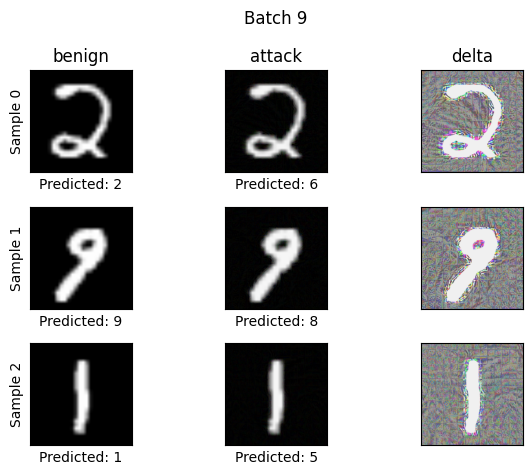

In [ ]:
def get_predicted_label(filepath):
    with open(filepath, "r") as infile:
        data = json.load(infile)
        return np.argmax(data["predictions"])


# strip off the initial 'file://' prefix
benign_artifact_uri = mlflow.get_run(results["benign"]["run_id"]).info.artifact_uri[7:]
attack_artifact_uri = mlflow.get_run(results["attack"]["run_id"]).info.artifact_uri[7:]

batch_idx = num_batches - 1
num_samples = min(3, batch_size)

fig, axes = plt.subplots(nrows=num_samples, ncols=3)

for sample_idx in range(num_samples):
    benign_image = plt.imread(
        f"{benign_artifact_uri}/{Exporter.artifact_path(batch_idx, sample_idx, 'input.png')}"
    )
    benign_label = get_predicted_label(
        f"{benign_artifact_uri}/{Exporter.artifact_path(batch_idx, sample_idx, 'metadata.txt')}"
    )
    attack_image = plt.imread(
        f"{attack_artifact_uri}/{Exporter.artifact_path(batch_idx, sample_idx, 'input.png')}"
    )
    attack_label = get_predicted_label(
        f"{attack_artifact_uri}/{Exporter.artifact_path(batch_idx, sample_idx, 'metadata.txt')}"
    )

    # shift by eps so the delta has a min of 0, then multiply by 10 to make the diff more pronounced
    delta_image = ((benign_image - attack_image) + art_pgd.eps) * 10

    if sample_idx == 0:
        axes[sample_idx][0].set_title("benign")
        axes[sample_idx][1].set_title("attack")
        axes[sample_idx][2].set_title("delta")

    axes[sample_idx][0].set_ylabel(f"Sample {sample_idx}")

    axes[sample_idx][0].imshow(benign_image)
    axes[sample_idx][0].set_xlabel(f"Predicted: {benign_label}")

    axes[sample_idx][1].imshow(attack_image)
    axes[sample_idx][1].set_xlabel(f"Predicted: {attack_label}")

    axes[sample_idx][2].imshow(delta_image)

    for col in range(3):
        axes[sample_idx][col].tick_params(
            bottom=False, left=False, labelbottom=False, labelleft=False
        )

fig.suptitle(f"Batch {batch_idx}")
fig.tight_layout()